# Traffic_Sign_Classifier-with-Streamlit


# Project overview

The aim of this project is to focus on the first fundamental features of the decision making ability of an autonomous vehicle, i.e., to develop a deep learning model that reads traffic signs and classifies them correctly using Convolutional Neural Networks(CNNs).

The traffic sign classifier uses a German traffic dataset. The German traffic dataset consists of 34,799 32*32 pixels colored images that is used for the training dataset, 12,630 images are used for the testing dataset and 4410 images are used in the validation dataset where each images is a photo of a traffic sign belonging to one of the 43 classes i.e., traffic sign types.

# Importing Libraries

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import random
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense,Dropout,Flatten , Activation , Input
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)

# Loading the dataset

In [233]:
# data of classes , each class and what the sign name
df = pd.read_csv("D:/Traffic_Sign_Classifier_with_Streamlit/signnames.csv") 
  
with open('D:/Traffic_Sign_Classifier_with_Streamlit/train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('D:/Traffic_Sign_Classifier_with_Streamlit/valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('D:/Traffic_Sign_Classifier_with_Streamlit/test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


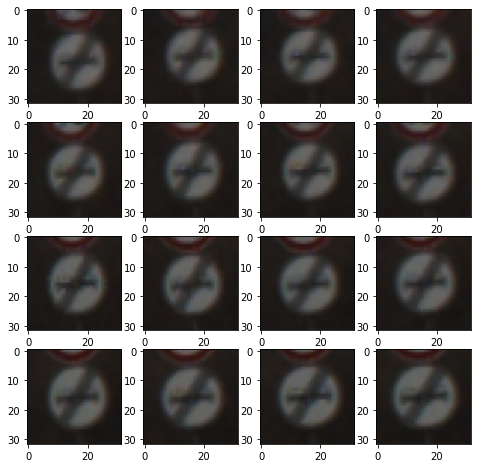

In [196]:
#Show a batch of images
fig , axis = plt.subplots(4,4,figsize=(8,8))
c=0
for i in range(4):
    for j in range(4):
        axis[i][j].imshow(x_train[c])
        c+=1

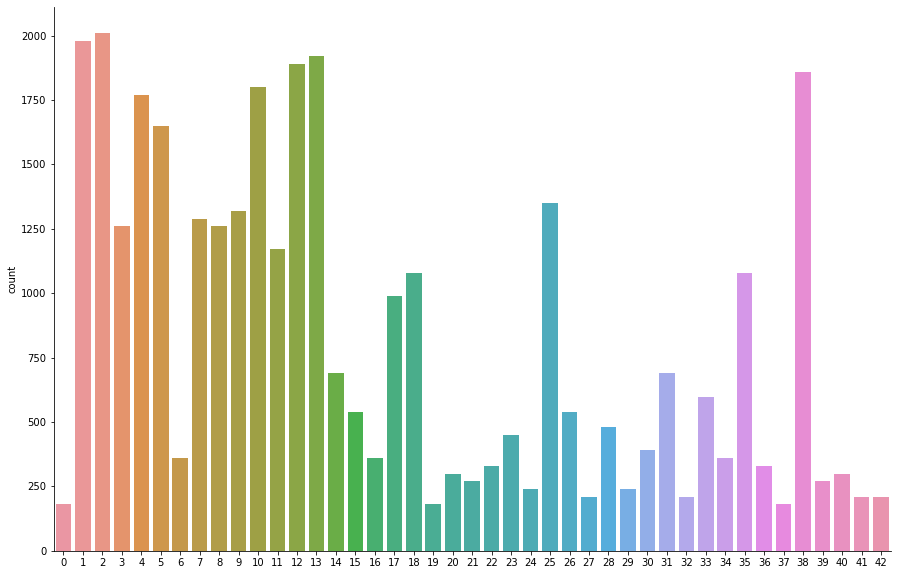

In [57]:
# Visualizing the img data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(x="labels", data=train_data)
sns.despine()

# Image Processing & Image Augmentation


In [58]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 

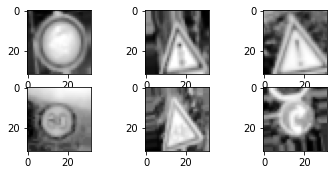

In [250]:
# Image Augmentation 
datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

root = 'D:\Traffic_Sign_Classifier_with_Streamlit/images'
#os.makedirs(root)

batch_size = 8

#Generate batches of tensor image data with real-time data augmentation.
# use datagen.flow here to show a batch of imgs(8)
for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir=root ,save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train_final = to_categorical(y_train, 43) 
y_val_final = to_categorical(y_val, 43) 
y_test_final = to_categorical(y_test, 43) 

In [60]:
#to_categorical transform your training data before you pass it to your model. If your training data uses
#classes as numbers, to_categorical will transform those numbers in proper vectors for using with models
a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
print(a)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [61]:
#Initialize use_cuda variable

use_cuda = torch.cuda.is_available()
use_cuda

False

# Build Model
 
 we wil use a pre-trained model (EfficientNetB1)

In [62]:
from tensorflow.keras.applications import EfficientNetB1

In [63]:
#Concatenate 3 black and white images together to expand color dimension to be apple to get into the pre-trained model
img_input = tf.keras.layers.Input(shape=(32, 32 ,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

base = EfficientNetB1(include_top=True, weights='imagenet', input_tensor=img_conc)
#base.summary()

In [64]:
Class_layer = Dense(43)(base.layers[-2].output)
    
Softmax_layer = Activation('softmax')(Class_layer)
    
    
model = Model(inputs=base.inputs, outputs=Softmax_layer)

# Freezing the base model weights and train only the classifier
for layer in base.layers:
    layer.trainable = False

In [49]:
#trainable_weights  is the list of those that are meant to be updated (via gradient descent) to minimize the loss during training.
#non_trainable_weights is the list of those that aren't meant to be trained. Typically they are updated by the model during the forward pass

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 32, 3)    0           ['input_6[0][0]',                
                                                                  'input_6[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 32, 32, 3)    0           ['concatenate_5[0][0]']          
                                                                                            

                                                                                                  
 block2a_expand_activation (Act  (None, 16, 16, 96)  0           ['block2a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 17, 17, 96)  0           ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 8, 8, 96)    864         ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_b

 block2c_bn (BatchNormalization  (None, 8, 8, 144)   576         ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 8, 8, 144)   0           ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 144)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2c_se_squeeze[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 4, 4, 240)    0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
          

 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 2, 2, 240)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 2, 2, 80)     19200       ['block4a_se_excite[0][0]']      
          

                                                                                                  
 block4c_project_bn (BatchNorma  (None, 2, 2, 80)    320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 2, 2, 80)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 2, 2, 80)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 2, 2, 480)    38400       ['block4c_add[0][0]']            
          

                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 2, 2, 672)   2688        ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 2, 2, 672)   0           ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 2, 2, 672)   16800       ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_b

 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 2, 2, 672)   16800       ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 2, 2, 672)   2688        ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 2, 2, 672)   0           ['block5d_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block6b_activation (Activation  (None, 1, 1, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 1, 1, 1152)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
          

                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 1, 1, 1152)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 1, 1, 320)    368640      ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 1, 1, 320)   1280        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
          

In [66]:
#Creating a Model Checkpoint
filepath="D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

In [67]:
opt = Adam(lr=1e-3)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Fitting the model
batch_size = 64
epochs = 40

import time
start_time = time.time()
if use_cuda:
    model = model.cuda()
    
efficientnet = model.fit(
                            datagen.flow(x_train_final, y_train_final, batch_size=batch_size), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(batch_size))),            # Num of batches
                            epochs = epochs, 
                            validation_data =(x_val_final, y_val_final),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/40
544/544 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.0532
Epoch 1: val_accuracy improved from -inf to 0.04762, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN.hdf5
544/544 [==============================] - 125s 208ms/step - loss: 0.1099 - accuracy: 0.0532 - val_loss: 0.1062 - val_accuracy: 0.0476
Epoch 2/40
544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0553
Epoch 2: val_accuracy improved from 0.04762 to 0.05442, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN.hdf5
544/544 [==============================] - 109s 201ms/step - loss: 0.1049 - accuracy: 0.0553 - val_loss: 0.1061 - val_accuracy: 0.0544
Epoch 3/40
544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0533
Epoch 3: val_accuracy improved from 0.05442 to 0.05488, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN.hdf5
544/

544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0557
Epoch 28: val_accuracy did not improve from 0.07596
544/544 [==============================] - 111s 205ms/step - loss: 0.1049 - accuracy: 0.0557 - val_loss: 0.1063 - val_accuracy: 0.0594
Epoch 29/40
544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0553
Epoch 29: val_accuracy did not improve from 0.07596
544/544 [==============================] - 110s 202ms/step - loss: 0.1049 - accuracy: 0.0553 - val_loss: 0.1059 - val_accuracy: 0.0476
Epoch 30/40
544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0546
Epoch 30: val_accuracy did not improve from 0.07596
544/544 [==============================] - 109s 200ms/step - loss: 0.1049 - accuracy: 0.0546 - val_loss: 0.1072 - val_accuracy: 0.0544
Epoch 31/40
544/544 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.0562
Epoch 31: val_accuracy did not improve from 0.07596
544/544 [==

In [68]:
#EfficientNetB1 give a low accuracy due to its complexity
# We need to reduce the complexity of the model
#let's try Using another and smaller model (MobileNetV2 )
from tensorflow.keras.applications import MobileNetV2 

In [104]:
#Concatenate 3 black and white images together to expand color dimension to be apple to get into the pre-trained model
img_input = tf.keras.layers.Input(shape=(32, 32 ,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    


base1 = MobileNetV2(include_top=True, weights='imagenet', input_tensor=img_conc)
#base1.summary()

In [100]:
model1 = Sequential([
  base1,
  Dropout(0.25),
  Dense(43, activation='softmax') ])

#Freezing the base model weights and train only the classifier
for layer in base1.layers:
    layer.trainable = False
    
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_28 (Dense)            (None, 43)                43043     
                                                                 
Total params: 3,582,027
Trainable params: 43,043
Non-trainable params: 3,538,984
_________________________________________________________________


In [101]:
#Creating a Model Checkpoint
filepath="D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN_2.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

In [103]:
opt = Adam(lr=1e-3)
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Fitting the model
batch_size = 64
epochs = 30

import time
start_time = time.time()
if use_cuda:
    model = model1.cuda()
    
mobilenet = model1.fit(
                            datagen.flow(x_train_final, y_train_final , batch_size=batch_size), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(batch_size))),            # Num of batches
                            epochs = epochs, 
                            validation_data =(x_val_final, y_val_final ),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/30
544/544 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.0572
Epoch 1: val_accuracy did not improve from 0.05442
544/544 [==============================] - 38s 67ms/step - loss: 0.2587 - accuracy: 0.0572 - val_loss: 0.1938 - val_accuracy: 0.0544
Epoch 2/30
544/544 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.0569
Epoch 2: val_accuracy improved from 0.05442 to 0.06281, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_2.hdf5
544/544 [==============================] - 36s 65ms/step - loss: 0.1633 - accuracy: 0.0569 - val_loss: 0.1416 - val_accuracy: 0.0628
Epoch 3/30
544/544 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.0589
Epoch 3: val_accuracy did not improve from 0.06281
544/544 [==============================] - 35s 65ms/step - loss: 0.1299 - accuracy: 0.0589 - val_loss: 0.1215 - val_accuracy: 0.0544
Epoch 4/30
543/544 [============================>.] - ETA: 0s 

544/544 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.1157
Epoch 27: val_accuracy did not improve from 0.12404
544/544 [==============================] - 39s 71ms/step - loss: 0.1029 - accuracy: 0.1157 - val_loss: 0.1048 - val_accuracy: 0.1100
Epoch 28/30
544/544 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.1224
Epoch 28: val_accuracy improved from 0.12404 to 0.12834, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_2.hdf5
544/544 [==============================] - 38s 70ms/step - loss: 0.1029 - accuracy: 0.1224 - val_loss: 0.1048 - val_accuracy: 0.1283
Epoch 29/30
544/544 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.1193
Epoch 29: val_accuracy did not improve from 0.12834
544/544 [==============================] - 35s 64ms/step - loss: 0.1028 - accuracy: 0.1193 - val_loss: 0.1047 - val_accuracy: 0.1256
Epoch 30/30
544/544 [==============================] - ETA: 0s - los

In [105]:
# Still complex more than it should
# let's create our own model instead of transfer learning
# This time we will input our gray scale imgs without making it RGB

In [172]:
model=Sequential()
# layer 1
model.add(Conv2D(filters=32,kernel_size=(2,2),activation="relu",padding="same",input_shape=(32,32,1),kernel_regularizer= l2(0.0005)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer = l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer = l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(43, activation='softmax'))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=["accuracy"])

In [173]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        160       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_69 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 8, 8, 64)        

In [174]:
#Creating a Model Checkpoint
filepath="D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN_3.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]
# Fitting the model
batch_size = 64
epochs = 1

import time
start_time = time.time()
if use_cuda:
    model = model.cuda()
    
MODEL = model.fit(
                            datagen.flow(x_train_final, y_train_final , batch_size=batch_size), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(batch_size))),            # Num of batches
                            epochs = epochs, 
                            validation_data =(x_val_final, y_val_final),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

544/544 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.0780
Epoch 1: val_accuracy improved from -inf to 0.13832, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_3.hdf5
544/544 [==============================] - 92s 166ms/step - loss: 0.1207 - accuracy: 0.0780 - val_loss: 0.1070 - val_accuracy: 0.1383

Duration: 92 seconds


# Fine Tuning to find the best hyperparameters

Using the same model will try to find the best possible heperparam to acheive the best performance

Implementing the Model:

In [176]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),activation='relu',
                     input_shape=(32,32,1),  padding='same', kernel_regularizer = l2(0.0005) ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]), activation='relu',
                     padding='same',kernel_regularizer = l2(0.0005)  ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu', padding='same',kernel_regularizer = l2(0.0005)  ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())
    
    model.add(Dense(hp.Int('DENSE_1_LAYER',min_value=32, max_value=512),
                    activation = hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'], default='relu')))
    
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [178]:
#Install Keras-tuner
# !pip install keras-tuner

In [179]:
#Use RandomSearch using keraatuner to find the best hyperparameters
from kerastuner import RandomSearch

In [180]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials = 10, 
                     
                     directory='D:\Traffic_Sign_Classifier_with_Streamlit', project_name="Traffic_Sign_Classifier")

In [181]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
CONV_1_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': None}
KERNEL_1_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_2_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_2_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_3_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_3_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 

In [182]:
tuner.search(x_train_final , y_train_final , epochs=1, validation_data=(x_val_final,y_val_final))

Trial 10 Complete [00h 02m 28s]
val_accuracy: 0.21655328571796417

Best val_accuracy So Far: 0.8836734890937805
Total elapsed time: 00h 28m 06s
INFO:tensorflow:Oracle triggered exit


In [183]:
fmodel = tuner.get_best_models(num_models=1)[0]

In [184]:
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 46)        460       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 46)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 46)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 69)        79419     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 69)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 69)          0

In [197]:
#Creating a Model Checkpoint
filepath="D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN_3.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]
# Fitting the model
batch_size = 64
epochs = 30

import time
start_time = time.time()
if use_cuda:
    model = fmodel.cuda()
    
MODEL = fmodel.fit(
                            datagen.flow(x_train_final, y_train_final, batch_size=batch_size), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(batch_size))),            # Num of batches
                            epochs = epochs, 
                            validation_data =(x_val_final, y_val_final),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 1/30
544/544 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.8736
Epoch 1: val_accuracy improved from -inf to 0.93923, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_3.hdf5
544/544 [==============================] - 107s 196ms/step - loss: 0.5508 - accuracy: 0.8736 - val_loss: 0.3341 - val_accuracy: 0.9392
Epoch 2/30
544/544 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.8982
Epoch 2: val_accuracy improved from 0.93923 to 0.95488, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_3.hdf5
544/544 [==============================] - 110s 202ms/step - loss: 0.4682 - accuracy: 0.8982 - val_loss: 0.2861 - val_accuracy: 0.9549
Epoch 3/30
544/544 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.9083
Epoch 3: val_accuracy improved from 0.95488 to 0.96304, saving model to D:\Traffic_Sign_Classifier_with_Streamlit\Traffic_Sign_Classifier_CNN_3.hdf

544/544 [==============================] - 112s 206ms/step - loss: 0.3388 - accuracy: 0.9382 - val_loss: 0.2497 - val_accuracy: 0.9698
Epoch 28/30
544/544 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.9396
Epoch 28: val_accuracy did not improve from 0.97302
544/544 [==============================] - 113s 207ms/step - loss: 0.3378 - accuracy: 0.9396 - val_loss: 0.2741 - val_accuracy: 0.9617
Epoch 29/30
544/544 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.9386
Epoch 29: val_accuracy did not improve from 0.97302
544/544 [==============================] - 111s 203ms/step - loss: 0.3367 - accuracy: 0.9386 - val_loss: 0.2498 - val_accuracy: 0.9683
Epoch 30/30
544/544 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.9418
Epoch 30: val_accuracy did not improve from 0.97302
544/544 [==============================] - 113s 208ms/step - loss: 0.3282 - accuracy: 0.9418 - val_loss: 0.2803 - val_accuracy: 0.9571

Duration: 40

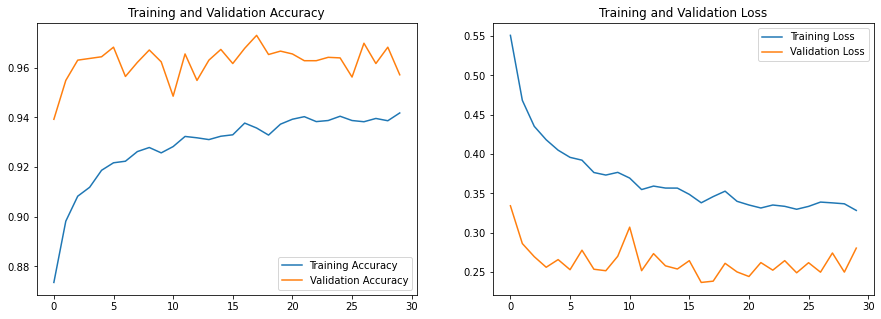

In [204]:
acc = MODEL.history['accuracy']
val_acc = MODEL.history['val_accuracy']

loss = MODEL.history['loss']
val_loss = MODEL.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Load the model's weights and biases for evaluation on Test set

In [251]:
fmodel.load_weights("D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN_3.hdf5")
fmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [255]:
Pred = fmodel.evaluate(x_test_final, y_test_final, verbose=1)
print("Results on the test data")
print("%s- %.4f" % (fmodel.metrics_names[0], Pred[0]))
print("%s- %.4f" % (fmodel.metrics_names[1], Pred[1]))

395/395 [==============================] - 9s 22ms/step - loss: 0.3364 - accuracy: 0.9391
Results on the test data
loss- 0.3364
accuracy- 0.9391


Predicted Sign [0]
Actual lapel : 0


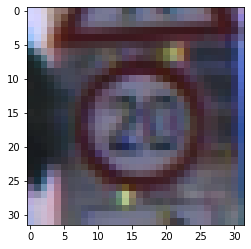

In [253]:
#Testing the model on the test dataset
plt.imshow(x_test[990]) 
#print("Predicted sign: "+ str( fmodel.predict(x_test_final[990].reshape(1, 32, 32, 1))))

classes = str( np.argmax( fmodel.predict( x_test_final[990].reshape(1,32,32,1)) , axis=1))
print('Predicted Sign' , classes)
print('Actual lapel :' , y_test[990])

Predicted Sign [12]
Actual lapel : 12


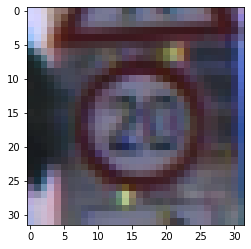

In [254]:
#Testing the model on the test dataset
plt.imshow(x_test[990]) 
#print("Predicted sign: "+ str( fmodel.predict(x_test_final[7].reshape(1, 32, 32, 1))))

classes = str( np.argmax( fmodel.predict( x_test_final[7].reshape(1,32,32,1)) , axis=1))
print('Predicted Sign' , classes)
print('Actual lapel :' , y_test[7])

# Saving and loading the model

In [257]:
fmodel.save('D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN.hdf5')

In [259]:
from tensorflow.keras.models import load_model

loaded_model = load_model('D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN.hdf5')

# Testing our saved model on a random traffic sign image

In [277]:
df

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


14


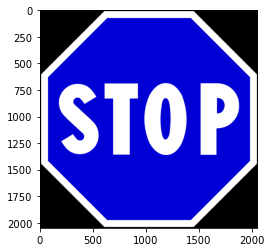

In [291]:
from tensorflow.keras.models import load_model

import cv2
import numpy as np


model = load_model('D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN.hdf5')

img = cv2.imread('D:/stop.png')
plt.imshow(img )

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 


img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = np.argmax( model.predict(img) )

print(classes)
# Stop sign is number 14

33


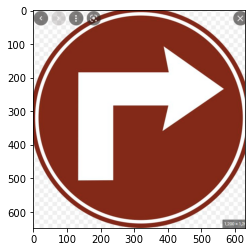

In [295]:
from tensorflow.keras.models import load_model

import cv2
import numpy as np


model = load_model('D:\Traffic_Sign_Classifier_with_Streamlit/Traffic_Sign_Classifier_CNN.hdf5')

img = cv2.imread('D:/turn_right.jpg')
plt.imshow(img )

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = np.argmax( model.predict(img) )
#classes = str( np.argmax( model.predict( x_test_final[7].reshape(1,32,32,1)) , axis=1))

print(classes)
# Turn right is number  33

#from PIL import Image
#Image.open('D:/turn_right.jpg')